In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np

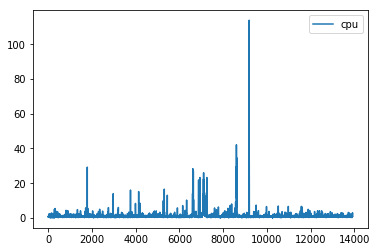

In [18]:
dataset = pd.read_csv('cpu.csv', header=None, names=['cpu'])
dataset.plot()

In [4]:
# prepare data
num_features = dataset.shape[1] # number feature = 1
num_data_in = 4 # sequence length
num_data_out = 1 # sequence length output

In [5]:
#convert series to supervised learning
def series_to_suppervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n...t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1,...t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with Nan values
    if(dropnan):
        agg.dropna(inplace=True)
    return agg


In [6]:
data = dataset.values
data_df = series_to_suppervised(data, num_data_in, num_data_out)
data_df.head()

,var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
4,0.668381,0.668381,0.739129,0.739129,0.558318
5,0.668381,0.739129,0.739129,0.558318,0.539101
6,0.739129,0.739129,0.558318,0.539101,0.539101
7,0.739129,0.558318,0.539101,0.539101,0.959187
8,0.558318,0.539101,0.539101,0.959187,0.959187


In [7]:
data = data_df.values
data.shape

(13916, 5)

In [8]:
X = data[:, :-1]
y = data[:, -1]
print(X.shape, y.shape)

(13916, 4) (13916,)


In [9]:
X = np.reshape(X, (X.shape[0], X.shape[1], num_features))
print(X.shape)

(13916, 4, 1)


In [10]:
batch_x = X[:10, :]
batch_x.shape

(10, 4, 1)

In [11]:
tf.reset_default_graph()
tf_x = tf.constant(dtype=tf.float32, value=X[:10,:])
cell = tf.contrib.rnn.LSTMCell(num_units=100)
output, state = tf.nn.dynamic_rnn(cell=cell, inputs=tf_x, dtype=tf.float32)

In [12]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    writer = tf.summary.FileWriter('.', sess.graph)
    out, sta = sess.run([output, state])
    print(out.shape, sta.h)

(10, 4, 100) [[ 5.85545506e-03  2.58495528e-02 -3.82531062e-02 -1.07275287e-03
   2.74770930e-02 -9.55925789e-03  4.64361310e-02 -1.61798913e-02
   2.00657286e-02 -2.60657724e-02  6.02018051e-02  3.67846191e-02
   1.06071467e-02 -9.33870114e-03  2.04451419e-02 -2.60616895e-02
  -7.76561629e-03  4.72947322e-02  4.07589115e-02  2.31764335e-02
  -1.42943328e-02 -2.72567738e-02 -2.07410865e-02 -6.56943826e-04
  -4.26268438e-03 -3.29956226e-02 -4.84049395e-02  4.77611758e-02
  -5.06115668e-02 -8.13105982e-03  3.52609679e-02 -3.10137086e-02
  -1.64294802e-02 -2.88530122e-02  4.65815775e-02  6.75983785e-04
   4.83573712e-02  2.33866181e-02  3.43272239e-02 -3.31336074e-02
  -2.81353872e-02 -1.78201217e-02 -3.82178575e-02 -1.91748068e-02
  -2.52660736e-03 -1.88612826e-02 -3.74554507e-02  8.80568661e-03
   2.51557417e-02 -2.21289750e-02 -2.93726791e-02 -1.79316569e-02
  -3.14006247e-02 -1.63180158e-02 -2.39433311e-02 -1.26376459e-02
   1.12107433e-02  2.10216809e-02 -3.06139812e-02 -3.04563567e-

In [13]:
# hyperparameter
num_layers = 2
sequence_length_encoder = 8 # T
sequence_length_decoder = 4 # F


In [14]:
# prepare data
data = list(range(1,100,1))
df_encode = series_to_suppervised(data=data, n_in=sequence_length_encoder)
df_decode = series_to_suppervised(data=data, n_in=sequence_length_decoder, n_out=sequence_length_decoder)

print(df_encode.shape, df_decode.shape)

(91, 9) (92, 8)


In [15]:
x_encode = df_encode.iloc[:, :sequence_length_encoder].values
y_encode = df_encode.iloc[:, sequence_length_encoder:].values
x_encode = np.reshape(x_encode, (x_encode.shape[0], x_encode.shape[1], 1))
print(x_encode.shape, y_encode.shape)

(91, 8, 1) (91, 1)


In [16]:
def build_encoder(layers):
    cells = []
    for i in range(len(layers)):
        cells.append(tf.contrib.rnn.LSTMCell(num_units=layers[i]))
    model = tf.contrib.rnn.MultiRNNCell(cells=cells)
    return model

def fit_encoder(cell, inputs, initial_state):
    output, state = tf.nn.dynamic_rnn(cell=cell, inputs=inputs, dtype=tf.float32)
    return output, state

In [17]:
layers = [10]
tf.reset_default_graph()
x = tf.constant(dtype=tf.float32, value=x_encode)
encoder=build_encoder(layers=layers)
init_state = tf.zeros(dtype=tf.float32, shape=())
output, state = fit_encoder(encoder, x, init_state)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    writer = tf.summary.FileWriter('.', sess.graph)
